___

<center><h1>IMBD Classification Movie Reviews - DL</h1></center>

___

<center><h2>DSM0150 - Neural Networks</h2></center><br>
<center><strong>Teacher:</strong> Tim Blackwell</center>

___
<p></p>
<center style="color: #AA6373; font-weight: 400;"><strong>Presented by:</strong></center>
<center style="color: #AA6373; font-weight: 400;">Jorge Forero L.</center>
<center style="color: #AA6373; font-weight: 400;">Student Number: 240323983</center>
<center style="color: #AA6373; font-weight: 400;">Student Portal Username: JEFL1</center>
<center>March 2025</center>
<p></p>
___

## 1. Introduction & Problem Statement
<p></p>
This project focuses on the task of sentiment analysis by classifying movie reviews from the IMDB dataset as either positive or negative. We employ a series of deep learning techniques—starting with a baseline dense network and advancing to recurrent neural networks—to illustrate how model performance can be progressively refined. This progression mirrors real-world scenarios where data scientists must continuously enhance models to meet stringent business requirements.

Such challenges are particularly relevant for C2C companies, which rely on evolving predictive models as a primary tool for understanding customer behavior and driving strategic decisions. The project demonstrates not only the technical evolution of deep learning approaches but also the practical considerations of model development in an industrial context.

The entire analysis, including data preprocessing, model development, and evaluation, is version-controlled and hosted on GitHub to facilitate reproducibility and collaboration. You can view and contribute to the project at the following URL: https://github.com/jforeroluque/DSM150_NeuralNetworks_CW2.

<p></p>


### Aims and Objectives
<p></p>
The primary aim of this project is to develop and evaluate deep learning models for sentiment analysis on the IMDB movie reviews dataset, showcasing the evolution from a simple baseline to an advanced recurrent model—mirroring the iterative refinement process in real-world industry applications.
<p></p>

#### Objectives
<p></p>

1. Preprocess and explore the IMBD dataset (Vectorization, sequence padding)
2. Build a feed-forward neural network with dense and droput layers as a performance benchmark
3. Develop an RNN using an Embedding layer and Bidirectional LSTM layers, integrating techniques like drioput and EarlyStopping
4. Assess the models with metrics such as accuracy, precision, recall, F1-Score, and confusion matrices
5. Compare the model performance and discuss implicatons for implications for iterative model refinement in industry

<p></p>

#### Ethical Considerations
<p></p>

Transparency and Reproducibility
All steps of data preprocessing, model design, and hyperparameter tuning have been documented to ensure that others can replicate and validate the findings. Code and plots are presented in a notebook format for clarity and reproducibility.

For this Coursework we will be improving the results obtained in the previous one, where we got the following results:



In [1]:
# Common Modules

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


## 2. Data Understanding 

For this project, we use the IMDB movie review dataset, which contains 50000 reviews split evenly between training and test sets. Each review is encoded as a sequence of word indices, and we restrict the vocabulary to the top 10000 most frequent words to reduce noise and control dimensionality.

We began by exploing the dataset's characteristics, including the distribution of review lenghts and class balance, with this initial analysis we set up our models:

- Baseline Model:
Reviews are vectorized into multi-hot encoded vectors, capturing the presence of words but not their order. This simple representation support a feed-forward neural network with Dense and Droput layers as a performance benchmark

- Recurrent Model:
For this model we wanted to capture the sequential nature of language, so the reviews are padded to a fixed lenght of 500 words and processed through an Embedding layer. This enables the use of Bidirectional LSTM layers, which better preserve contextual information and address some of the limitations of the baseline approach.

### Limitations and constrains of the Data 

While the IMDB dataset is a valuable resource for exploring sentiment classification, it presents several limitations and constraints that may influence our analysis and model performance:

1. Limiting the vocabulary to 10000 words may exclude less frequent yet meaningful words, potentially oversimplifying the representation of sentiment
2. The multi-hot encodingused in the baseline model disregards word order, which can impede the model's ability to understand context, such as negation or sarcasm. We address this partially with the recurrent model.
3. Padding all reviews to 500 words simplifies processing but may truncate longer reviews or add unnecessary padding to shorter ones, affecting the model's performance.

### Data Load

In [2]:
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words) # Reference [1] 

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))

Training samples: 25000
Test samples: 25000


### Exploratory Data Analysis

**Sequence Lenght Analysis**

We analyzed the distribution of review lenghts to understand the way it varies in the dataset and determine an optimal fixed sequence lenght for padding, ensuring that the majority of reviews are adequately represented without excessive truncation 

Minimum review length: 11
Maximum review length: 2494
Average review length: 238.71


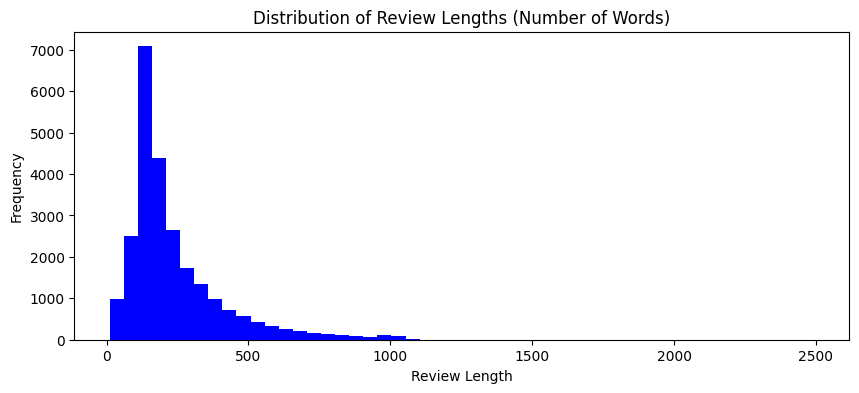

In [3]:
review_lengths = [len(sequence) for sequence in x_train]

print(f"Minimum review length: {np.min(review_lengths)}")
print(f"Maximum review length: {np.max(review_lengths)}")
print(f"Average review length: {np.mean(review_lengths):.2f}")

plt.figure(figsize=(10,4))
plt.hist(review_lengths, bins=50, color='blue')
plt.title("Distribution of Review Lengths (Number of Words)")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()

Our analysis shows that most IMDB reviews fall under 500 words, with relatively few extending beyond that, guiding our decision to pad sequences to a fixed length of 500.

#### Data Preprocessing

For this we will be using Kera's pad_sequences with a maximum length of 500 words, truncating longer reviews and padding shorter ones with zeros, to ensure a uniform input shape for the model

In [4]:
maxlen = 500
x_train_padded = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_padded = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

## 2. Baseline Model Implementation (Naive Model) [Reference 2]

For this baseline feed-forward model we will be using 3 Dense layers of 32 units and a 0.5 droput that did pretty well on the training accuracy but it started to overfiting around epoch 6. We can see it because the validation loss diverges from the training loss. To adress this we could make some adjustments by experiment with early stopping, different dropout rates, and adjusting the number of epochs. Since this is a baseline model we will be keeping it as is so we can compare results later in the notebook.

In [5]:
def vectorize_sequences(sequences, dimension=10000): # Reference [1]
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

# Convert labels to float32
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [6]:
#Here's the architecture of the model [Reference 3]
model_dropout = Sequential([
    Input(shape=(10000,)),           
    Dense(32, activation='relu'),   
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [7]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [8]:
model_dropout.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_dropout = model_dropout.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=1024,
    validation_data=(x_val, y_val)
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5492 - loss: 0.6844 - val_accuracy: 0.8126 - val_loss: 0.5904
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7216 - loss: 0.5796 - val_accuracy: 0.8541 - val_loss: 0.4470
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8197 - loss: 0.4560 - val_accuracy: 0.8697 - val_loss: 0.3528
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8665 - loss: 0.3599 - val_accuracy: 0.8842 - val_loss: 0.3044
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8962 - loss: 0.2973 - val_accuracy: 0.8895 - val_loss: 0.2795
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9149 - loss: 0.2489 - val_accuracy: 0.8907 - val_loss: 0.2700
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9333 - loss: 0.2101 - val_accuracy: 0.8880 - val_loss: 0.2763
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9397 - loss: 0.1877 - val_accuracy: 0.8878 - v

In [9]:
# Extracting history
history_dict = history_dropout.history
training_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

epochs_range = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(12,4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

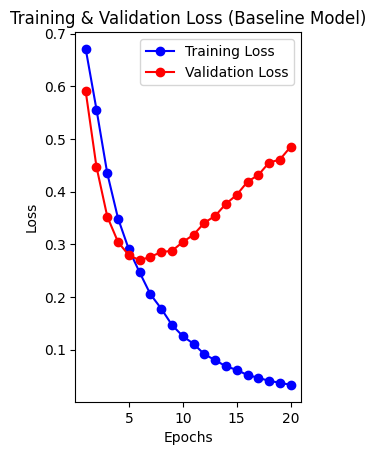

In [10]:
# Plot loss
plt.subplot(1,2,1)
plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss (Baseline Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#### Performance metrics

Since we will be comparing the performance of the 2 models we will be needing to have more meauserements for the overall performance of both models, that's why it's important to alsow make masurements of Precision, Recall, F1_Score and the cart of confussion matrix.

In [11]:
# We this we get the predicted probabilities on the test set
y_pred_probs = model_dropout.predict(x_test)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = (y_pred_probs > 0.5).astype("int32")

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


In [12]:
# Computing the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [13]:
# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8763305435930772
Recall: 0.8628
F1 Score: 0.8695126375619785


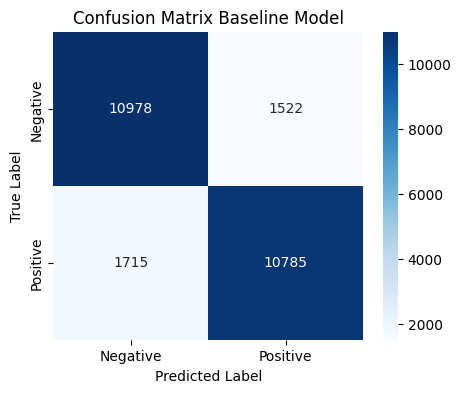

In [14]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix Baseline Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [15]:
# Here's a full classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87     12500
         1.0       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



## 3. Recurrent Neural Network Model [Reference 10]

Here we will be building a model that uses an Embedding layer to learn a dense representation for words, this to better capture the sequential context of each review. By embedding words and leveraging Bidirectional LSTM layers, we can preserve word order and context, thereby improving the model's ability to distiguish subtle differences in sentiment that a simple feed-forward network might overlook.

In [16]:
# RNN model architecture [Reference 4]
model_rnn = keras.Sequential([
    # Embedding layer - With this we intend to learn the representation of words in the dataset [Reference 7]
    layers.Embedding(input_dim=10000, output_dim=128),
      
    # First Bidirectional LSTM - This layer processes the input in both forward and backwards directions, this helps to capture context from both ends of the sentence which is useful in sentiment analysis
    layers.Bidirectional(
        layers.LSTM(
            64, 
            return_sequences=True, 
            dropout=0.2, 
            recurrent_dropout=0.2
        )
    ),
    
    # Second Bidirectional LSTM - With 32 units we intend to not return sequences, effectively summarizing the sequence information from prvious layer into a single vector [Reference 5]
    layers.Bidirectional(
        layers.LSTM(
            32, 
            dropout=0.3, 
            recurrent_dropout=0.3
        )
    ),
    
    # A final Dropout layer for extra regularization [Reference 6]
    layers.Dropout(0.3),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

In [17]:
# We will be using the Adam optimizer because of its adaptive learning rate properties
# We will be using binary crossentropy as the loss function because it is a binary classification problem
# We will be monitoring accuracy as the metric because we are interested on the proportion of correctly classified reviews
model_rnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
# EarlyStopping callback to prevent overfitting [Reference 8]
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, #With this we assure that the model will stop training when the validation loss does not improve after 2 epochs
    restore_best_weights=True
)

In [19]:
# Split into training & validation sets
x_val_rnn = x_train_padded[:10000]
partial_x_train_rnn = x_train_padded[10000:]
y_val_rnn = y_train[:10000]
partial_y_train_rnn = y_train[10000:]

In [20]:

# Train the model
history_rnn = model_rnn.fit(
    partial_x_train_rnn, 
    partial_y_train_rnn,
    epochs=10,
    batch_size=256,  # We tried different batch sizes and this one gave us the best results
    validation_data=(x_val_rnn, y_val_rnn),
    callbacks=[early_stopping]
)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.5952 - loss: 0.6563 - val_accuracy: 0.8047 - val_loss: 0.4383
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8400 - loss: 0.3914 - val_accuracy: 0.8414 - val_loss: 0.3727
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.8952 - loss: 0.2908 - val_accuracy: 0.8373 - val_loss: 0.3840
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9118 - loss: 0.2502 - val_accuracy: 0.8317 - val_loss: 0.4013


In [21]:
# Evaluate on test data
test_loss, test_acc = model_rnn.evaluate(x_test_padded, y_test)
print("Test accuracy:", test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.8379 - loss: 0.3776
Test accuracy: 0.8379200100898743


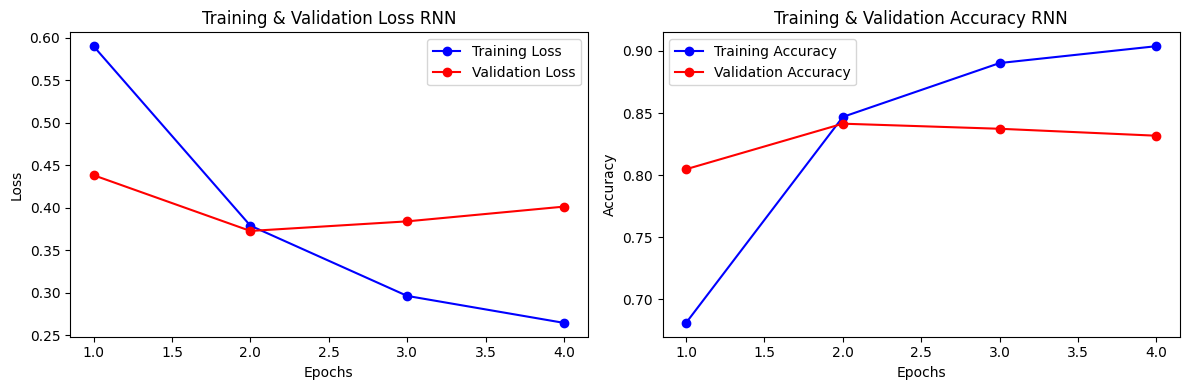

In [22]:
# Plotting
history_dict = history_rnn.history
epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history_dict['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Performance Metrics [Reference 9]

In [23]:
# Generation of predictions 
pred_probs = model_rnn.predict(x_test_padded)
pred_labels = (pred_probs > 0.5).astype("int32")

782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 100ms/step


In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_labels)

In [25]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)

In [26]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8161203412662775
Recall: 0.8724
F1-score: 0.8433222488593303


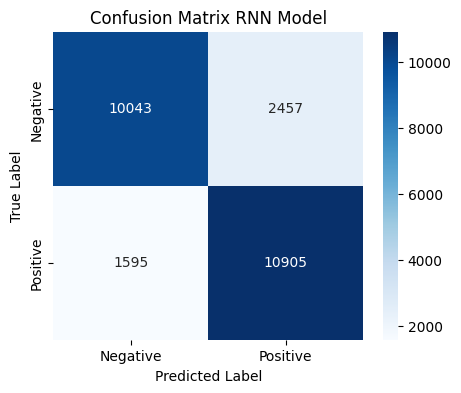

In [27]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix RNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
# Classification report
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83     12500
         1.0       0.82      0.87      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



## 6. Results and Comparison

For this project we could see that the baseline feed-forward model, emplying dense and dropout layers, surprisingly achieved around 87% accuracy on the IMBD test set. Althought it overfit on the training data, it still classified the majority of reviews correctly, maintaining balanced precision, recall and F1 scores. With the confusion matrix we saw a near-equal rate of misclassification between positive and negative reviews where we can see a relatively consistent performance across classes.

By contrast on the recurrent model with Embedding ad Bidirectional LSTM layers we reached about 84% accuracy. Despite of theoretically better handling a word order and context, it did not surpass the baseline model, but we have to take into account the setting time of it and we can also understand that even without the an hyperparameter tunning the RNN model had a great performance, which is something that many real case scenarios would accept in terms of simplicity and correct use of development time. This RNN result ilustrates that while recurrent architecture excel at sequence modeling, achieving optimal performance requires careful tuning and experimentation to fully leverage their strenghts.


## 7. Conclusions and Next Steps

This project helpd to demonstrate that even with a simple feed-forward model can perform robustly on sentiment classification tasks, achieving around 87% accuracy and balanced performance scores like precision, recall and F1 Scores. On the other hand, the recurrent model with embedding and bidirectional LSTM layers, althought theoretically superior in capturing word order and context, attained a slightly lower accuracy of about 84% without extensive hyperparameter tuning we can conclude the following:
- The dense and dropout-based baseline model, established a strong reference point because of the extensive work made on the Coursework 1.
- The recurrent architecture shows promise in handling sequential data: however, its performance is hightly sensitive to hyperparameters such as dropout rates and batch size, we can continue experimenting on that.
- We saw that this types of advanced architectures like RNNs offer potential benefits in theory, but practical preformance gains depend on meticulous tuning, balanced against development time constrains common in real-world scenarios.

For the next steps we can consider to conduct an extensive hyperparameter tuning on the RNN model to better harness its ability to capture contextual nuances, we can also recommend to explore additional architectures, such as multi-input ensemble methods, to increase the chance of improving. Once the final model is set we can also deploy the model as a Azure Function to conect it via Endppoint to the desired application.

## References

1.	TensorFlow. (n.d.). Keras Datasets: IMDB [Documentation]. Retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb
2.  Chollet, F. (2021). Deep Learning with Python (2nd ed. p. 328). Manning Publications.
3.  Faroit. (n.d.). Keras Sequential Model Guide [Documentation]. Retrieved from https://faroit.com/keras-docs/1.0.6/getting-started/sequential-model-guide/
4.	TensorFlow. (n.d.). Keras Sequential Model Guide [Documentation]. Retrieved from https://www.tensorflow.org/guide/keras/sequential_model
5.	Brownlee, J. (n.d.). Develop a Bidirectional LSTM for Sequence Classification in Python with Keras [Blog Post]. Retrieved from https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
6.	TensorFlow. (n.d.). Keras Layers Documentation [Documentation]. Retrieved from https://www.tensorflow.org/api_docs/python/tf/keras/layers
7.	TensorFlow. (n.d.). Keras Layers: Embedding [Documentation]. Retrieved from https://keras.io/2.15/api/layers/core_layers/embedding/
8.	TensorFlow. (n.d.). Keras Callbacks: EarlyStopping [Documentation]. Retrieved from https://keras.io/2.15/api/callbacks/early_stopping/
9.	scikit-learn. (n.d.). Classification Metrics [Documentation]. Retrieved from https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
10.  Olah, C. (2015). Understanding LSTM Networks [Blog Post]. Retrieved from http://colah.github.io/posts/2015-08-Understanding-LSTMs/

